# Linear separable models

## So far
+ We've covered two ways to do prediction with a single variable, classification using logistic regression and prediction using a line and least squares.
+ What if we have several predictiors? 
+ In both the logistic and linear regression models, we had a linear predictor, specifically, 

$$
\eta_i = \beta_0 + \beta_1 x_i.
$$

+ In the continuous case, we were modeling the expected value of the outcomes as linear. 
+ In the binary case, we were assuming that the naturual logarithm of the odds of a 1 outcome was linear. 

## Estimation

+ Minimize loss function for $\beta_0$ and $\beta_1$
+ Linear regression case

$$
\sum_{i=1}^n || y_i - \eta_i||^2 
$$

+ Logistic regression case

$$
-\sum_{i=1}^n \left[
  Y_i \eta_i + \log\left\{\frac{1}{1 + e^{\eta_i}} \right\} \right].
$$

## Extending these models

$$
\eta_i = \beta_0 + \beta_1 x_{1i} + \beta_2 x_{2i} + \ldots \beta_{p-1} x_{p-1,i}
$$

+ If we think about this as vectors and matrices, we obtain

$$
\eta = X \beta
$$

+ where $\eta$ is an $n \times 1$ vector, 
+ $X$ is an $n \times p$ matrix with $i,j$ entry $x_{ij}$
+ $\beta$ is a $p\times 1$ vector with entries $\beta_j$. 

# Example 

Consider our voxel level data

In [71]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn.linear_model as lm
import sklearn as skl
import statsmodels.formula.api as smf
import statsmodels as sm
## this sets some style parameters  
sns.set()
## Read in the data 
dat = pd.read_csv("https://raw.githubusercontent.com/bcaffo/ds4bme_intro/master/data/oasis.csv")

Proton density (PD) is the outcome, 

Let's first try to fit the proton density data from the other imaging data. 

In [72]:
trainFraction = .75

sample = np.random.uniform(size = 100) < trainFraction
trainingDat = dat[sample]
testingDat = dat[~sample]

In [73]:
results = smf.ols('PD ~ FLAIR + T1 + T2  + FLAIR_10 + T1_10 + T2_10 + FLAIR_20', 
                  data = trainingDat).fit()
# print(results.summary2())

```
# Truncated results
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.2099      0.130      1.610      0.112      -0.050       0.470
FLAIR         -0.0041      0.078     -0.053      0.958      -0.159       0.151
T1            -0.2987      0.089     -3.348      0.001      -0.477      -0.121
T2             0.5436      0.086      6.313      0.000       0.372       0.715
FLAIR_10      -0.0743      0.325     -0.228      0.820      -0.723       0.575
T1_10          0.2940      0.160      1.835      0.071      -0.026       0.614
T2_10          0.0066      0.310      0.021      0.983      -0.611       0.624
FLAIR_20       1.7173      0.696      2.466      0.016       0.328       3.106
==============================================================================
```

## Logistic regression example

In [74]:
x = dat[['FLAIR','T1', 'T2', 'FLAIR_10', 'T1_10', 'T2_10', 'FLAIR_20']]
y = dat[['GOLD_Lesions']]
## Add the intercept column
x = sm.tools.add_constant(x)
xtraining = x[sample]
xtesting = x[~sample]
ytraining = y[sample]
ytesting = y[~sample]

In [75]:
fit = sm.discrete.discrete_model.Logit(ytraining, xtraining).fit()

Optimization terminated successfully.
         Current function value: 0.253764
         Iterations 8


In [76]:
#fit.summary()()

```
            coef	std err	       z	P>|z|	 [0.025	0.975]
const	 -3.3909	1.767	  -1.919	0.055	 -6.854	  0.072
FLAIR	  1.5931	1.147	   1.389	0.165	 -0.655	  3.841
T1	      2.4984	1.086	   2.301	0.021	  0.371	  4.626
T2	      1.3153	0.994	   1.323	0.186	 -0.633	  3.263
FLAIR_10  8.6555	3.678	   2.353	0.019	  1.446	 15.865
T1_10	  1.6271	1.850	   0.879	0.379	 -1.999	  5.253
T2_10 	 -5.7317	3.572	  -1.605	0.109	-12.732	  1.269
FLAIR_20 -20.1731	8.786	  -2.296	0.022	-37.392	 -2.954
```

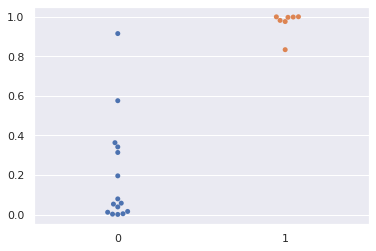

In [77]:
phatTesting = fit.predict(xtesting).to_numpy()
sns.swarmplot(x = np.squeeze(ytesting.to_numpy()), y=phatTesting);